# **Lung and Colon Cancer Image Classification Model**

- Lung benign tissue
- Lung adenocarcinoma
- Lung squamous cell carcinoma
- Colon adenocarcinoma
- Colon benign tissue

## 1. Data Installation

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")

print("Path to dataset files:", path)

c:\Users\ometh\anaconda3\envs\ai_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\ometh\.cache\kagglehub\datasets\andrewmvd\lung-and-colon-cancer-histopathological-images\versions\1


## 2. Import requird modules

In [ ]:
import torch
import torchvision
import torch.nn as nn #functions related to neural network
import torch.optim as optim #optimizer
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from sklearn.metrics import confusion_matrix, classification_report

## 3. Data Preprocessing and Normalization

In [3]:
class CancerDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        return self.data[index]
    
    @property
    def classes(self):
        return self.data.classes
    
    @property
    def targets(self):
        return self.data.targets

In [4]:
data_dir = r'C:\Users\ometh\.cache\kagglehub\datasets\andrewmvd\lung-and-colon-cancer-histopathological-images\versions\1\lung_colon_image_set'
dataset = CancerDataset(data_dir)

In [5]:
indices = list(range(len(dataset)))
labels = dataset.targets  # get class indices

# Split train (70%) vs temp (30%)
train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    indices, labels,
    test_size=0.3,
    stratify=labels, #take same propotion from each class
    random_state=42
)

# Split temp -> val (15%) and test (15%)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=temp_labels, #take same propotion from each class
    random_state=42
)


In [ ]:
# Only resize + tensor
basic_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = ImageFolder(root=data_dir, transform=basic_transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

# Finding the best mean and std for the dataset
mean = 0.
std = 0.
nb_samples = 0.

for images, _ in loader:
    # images shape: (batch_size, 3, 128, 128)
    batch_samples = images.size(0)  # batch size
    images = images.view(batch_samples, images.size(1), -1)  # (B, C, H*W)
    
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("Dataset mean:", mean)
print("Dataset std:", std)


In [7]:
# Define Data augmentations
mean=[0.7285, 0.5995, 0.8760] 
std=[0.1275, 0.1687, 0.0620]

# Training Transform
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5), #random left-right flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), #adjust brightness
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Validation Transform
val_transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Testing Transform
test_transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = Subset(ImageFolder(root=data_dir, transform=train_transform), train_idx)
val_dataset   = Subset(ImageFolder(root=data_dir, transform=val_transform), val_idx)
test_dataset  = Subset(ImageFolder(root=data_dir, transform=test_transform), test_idx)

print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

17500 3750 3750


In [8]:
# Checking the class imbalance
from collections import Counter

def class_counts(subset, all_classes):
    labels = [subset.dataset.targets[i] for i in subset.indices]
    counts = Counter(labels)
    return {all_classes[i]: counts[i] for i in range(len(all_classes))}

print("Train:", class_counts(train_dataset, dataset.classes))
print("Val:  ", class_counts(val_dataset, dataset.classes))
print("Test: ", class_counts(test_dataset, dataset.classes))


Train: {'colon_aca': 3500, 'colon_n': 3500, 'lung_aca': 3500, 'lung_n': 3500, 'lung_scc': 3500}
Val:   {'colon_aca': 750, 'colon_n': 750, 'lung_aca': 750, 'lung_n': 750, 'lung_scc': 750}
Test:  {'colon_aca': 750, 'colon_n': 750, 'lung_aca': 750, 'lung_n': 750, 'lung_scc': 750}


In [9]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)


torch.Size([32, 3, 128, 128]) torch.Size([32])


Training Dataset



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9656317..0.98778427].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7056698..0.7472451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.52066..0.6486369].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3318558..0.9233312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0937153..0.9409207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.27493..0.97263527].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0367893.

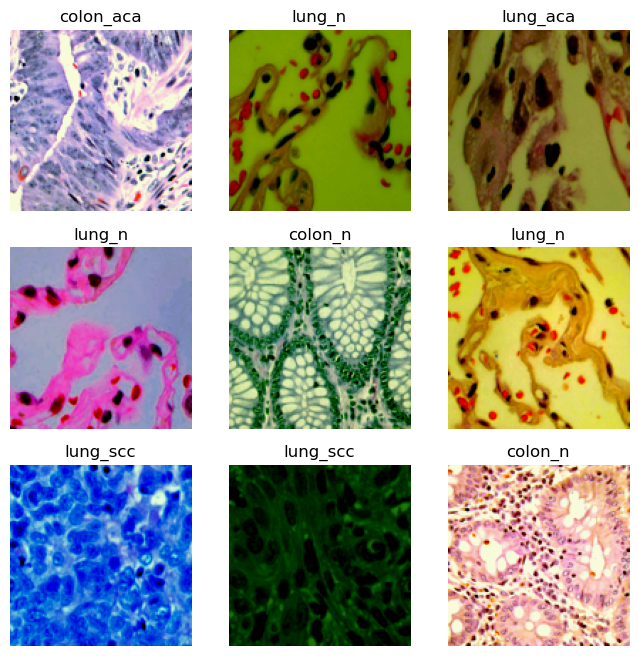

Testing Dataset



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1079468..0.9825772].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45329776..0.98778427].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3925768..0.98778427].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6383072..0.98778427].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.72369623..0.96174896].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.89447427..0.82753706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

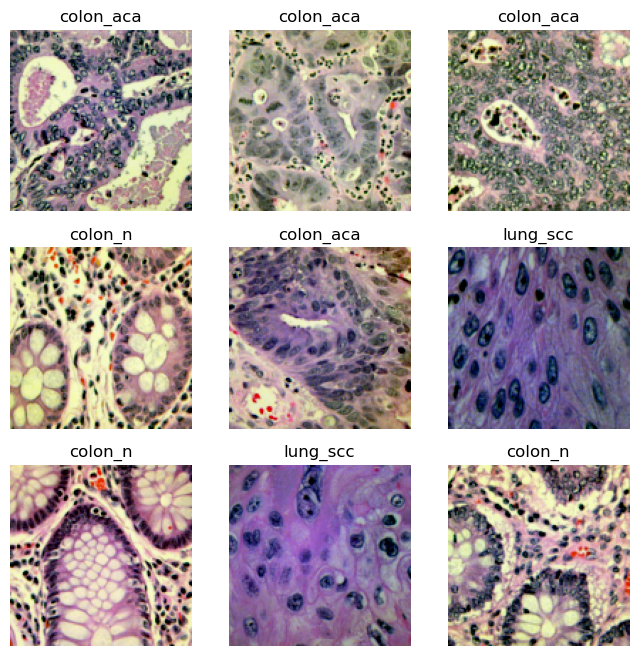

In [10]:
def visualise_images(loader, classes, n=9):
    images, labels = next(iter(loader))
    images, labels = images[:n], labels[:n]

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    images = images * std + mean

    fig, axes = plt.subplots(3, 3, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(classes[labels[i]])
        ax.axis("off")
    plt.show()

print("Training Dataset\n")
visualise_images(train_loader, dataset.classes)

print("Testing Dataset\n")
visualise_images(test_loader, dataset.classes)

## **Initializing the Convolutional Neural Network**

In [11]:
# Defining the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 224
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14
        )
        self.pool = nn.AdaptiveAvgPool2d(1)    # -> [B, C, 1, 1]
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)         # logits
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)   
print(device)


cuda


In [13]:
! pip install torchinfo

from torchinfo import summary

model = CNN(num_classes=5).to(device)

# summary(model, input_size=(batch, channels, height, width))
summary(model, input_size=(1, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 5]                    --
├─Sequential: 1-1                        [1, 256, 14, 14]          --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         896
│    └─BatchNorm2d: 2-2                  [1, 32, 224, 224]         64
│    └─ReLU: 2-3                         [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 32, 112, 112]         --
│    └─Conv2d: 2-5                       [1, 64, 112, 112]         18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 112, 112]         128
│    └─ReLU: 2-7                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-8                    [1, 64, 56, 56]           --
│    └─Conv2d: 2-9                       [1, 128, 56, 56]          73,856
│    └─BatchNorm2d: 2-10                 [1, 128, 56, 56]          256
│    └─ReLU: 2-11                        [1, 128, 56, 56]          --
│   

In [ ]:
from torch.cuda.amp import autocast, GradScaler

def train_model(model, train_loader, val_loader, criterion,
                optimizer_class, lr=3e-4, weight_decay=1e-2,
                scheduler_class=None, scheduler_params=None,
                device="cuda", num_epochs=50, print_batch=10):

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    model = model.to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = None
    if scheduler_class is not None:
        scheduler = scheduler_class(optimizer, **scheduler_params)

    scaler = GradScaler()

    for epoch in range(num_epochs):
        # ----- Training -----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)

            with autocast(): #remove autocast and organise the logits then grad, backward, optimizer
                logits = model(x)
                loss = criterion(logits, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # weighted by batch size
            running_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            if (i+1) % print_batch == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], "
                      f"Step [{i+1}/{len(train_loader)}], "
                      f"Loss: {loss.item():.4f}")

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] finished. "
              f"Avg Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        
        # ----- Validation -----
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                with autocast():
                    logits = model(x)
                    loss = criterion(logits, y)
                val_loss += loss.item() * y.size(0)
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        avg_val_loss = val_loss / val_total
        avg_val_acc = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)

        if scheduler:
            # For CosineAnnealingLR → step() is fine
            scheduler.step()
            # For ReduceLROnPlateau use: scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs


In [15]:
# val accuracy and loss plot function
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs_range = range(1, len(train_acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # Loss plot
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [16]:
import seaborn as sns
# eval model function
class_names = ["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"]

def eval_model(model, test_loader, class_names, device="cuda"):
    model.eval()  # set to eval mode
    y_true, y_pred = [], []

    with torch.no_grad():  # no gradient calculation needed
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)  # forward pass
            preds = torch.argmax(logits, dim=1)  # predicted classes

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print("\nClassification Report:\n", report)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR

train_losses, val_losses, train_accs, val_accs = train_model(
                                                    model,
                                                    train_loader=train_loader,
                                                    val_loader= val_loader,
                                                    criterion=criterion,
                                                    optimizer_class=optimizer,
                                                    lr=1e-3,
                                                    weight_decay=1e-2,
                                                    scheduler_class=None,
                                                    device="cuda",
                                                    num_epochs=50
                                                )

C:\Users\ometh\AppData\Local\Temp\ipykernel_30524\1571575163.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\ometh\AppData\Local\Temp\ipykernel_30524\1571575163.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Step [10/547], Loss: 1.0396
Epoch [1/50], Step [20/547], Loss: 0.9591
Epoch [1/50], Step [30/547], Loss: 0.7452
Epoch [1/50], Step [40/547], Loss: 1.0370
Epoch [1/50], Step [50/547], Loss: 1.3350
Epoch [1/50], Step [60/547], Loss: 0.5246
Epoch [1/50], Step [70/547], Loss: 0.5575
Epoch [1/50], Step [80/547], Loss: 0.5532
Epoch [1/50], Step [90/547], Loss: 0.6383
Epoch [1/50], Step [100/547], Loss: 0.7400
Epoch [1/50], Step [110/547], Loss: 0.6204
Epoch [1/50], Step [120/547], Loss: 0.3790
Epoch [1/50], Step [130/547], Loss: 0.6695
Epoch [1/50], Step [140/547], Loss: 0.5799
Epoch [1/50], Step [150/547], Loss: 0.7530
Epoch [1/50], Step [160/547], Loss: 0.5094
Epoch [1/50], Step [170/547], Loss: 0.2751
Epoch [1/50], Step [180/547], Loss: 0.3566
Epoch [1/50], Step [190/547], Loss: 0.4875
Epoch [1/50], Step [200/547], Loss: 0.6540
Epoch [1/50], Step [210/547], Loss: 0.5809
Epoch [1/50], Step [220/547], Loss: 0.7492
Epoch [1/50], Step [230/547], Loss: 0.6755
Epoch [1/50], Step [

C:\Users\ometh\AppData\Local\Temp\ipykernel_30524\1571575163.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50] Train Loss: 0.5185, Train Acc: 0.7782, Val Loss: 0.2104, Val Acc: 0.9195
Epoch [2/50], Step [10/547], Loss: 0.4771
Epoch [2/50], Step [20/547], Loss: 0.4965
Epoch [2/50], Step [30/547], Loss: 0.2188
Epoch [2/50], Step [40/547], Loss: 0.5545
Epoch [2/50], Step [50/547], Loss: 0.3673
Epoch [2/50], Step [60/547], Loss: 0.1354
Epoch [2/50], Step [70/547], Loss: 0.3450
Epoch [2/50], Step [80/547], Loss: 0.1696
Epoch [2/50], Step [90/547], Loss: 0.1912
Epoch [2/50], Step [100/547], Loss: 0.4978
Epoch [2/50], Step [110/547], Loss: 0.5286
Epoch [2/50], Step [120/547], Loss: 0.2669
Epoch [2/50], Step [130/547], Loss: 0.2465
Epoch [2/50], Step [140/547], Loss: 0.1972
Epoch [2/50], Step [150/547], Loss: 0.4876
Epoch [2/50], Step [160/547], Loss: 0.3691
Epoch [2/50], Step [170/547], Loss: 0.2695
Epoch [2/50], Step [180/547], Loss: 0.2142
Epoch [2/50], Step [190/547], Loss: 0.6316
Epoch [2/50], Step [200/547], Loss: 0.3740
Epoch [2/50], Step [210/547], Loss: 0.3628
Epoch [2/50], Step [

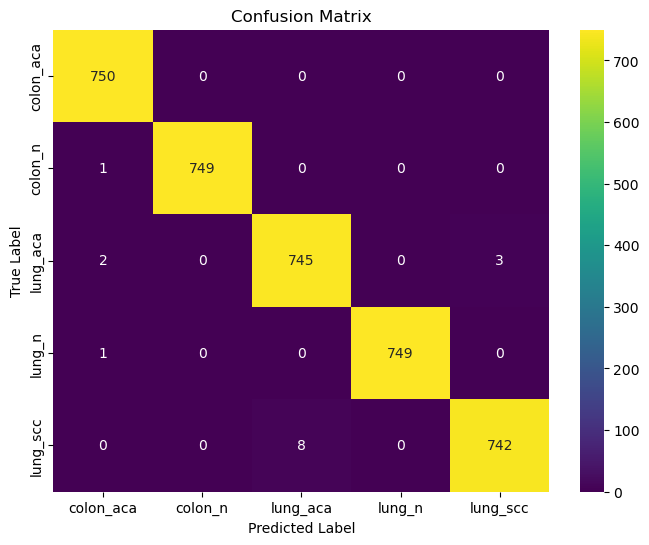


Classification Report:
               precision    recall  f1-score   support

   colon_aca     0.9947    1.0000    0.9973       750
     colon_n     1.0000    0.9987    0.9993       750
    lung_aca     0.9894    0.9933    0.9914       750
      lung_n     1.0000    0.9987    0.9993       750
    lung_scc     0.9960    0.9893    0.9926       750

    accuracy                         0.9960      3750
   macro avg     0.9960    0.9960    0.9960      3750
weighted avg     0.9960    0.9960    0.9960      3750



In [21]:
eval_model(model, test_loader, class_names, device=device)

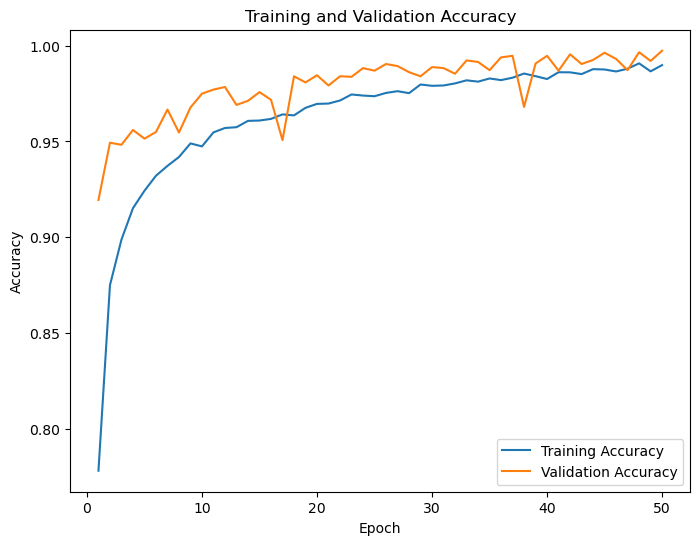

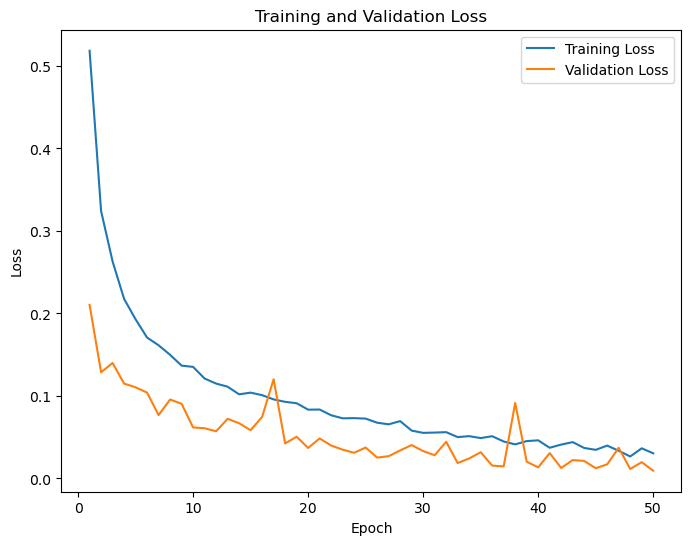

In [22]:
plot_metrics(train_accs, val_accs, train_losses, val_losses)